<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

['main.ipynb', 'func1.py']

In [28]:
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
import argparse, os, sys
import cv2
from PIL import Image

Dataset: 300W https://ibug.doc.ic.ac.uk/resources/300-W/

## Data preparation

In [18]:
# https://github.com/musyoku/face-alignment-at-3000fps/blob/master/run/train.py

def load_annotations(directory):
	annotations = {}
	fs = os.listdir(directory)
	for filename in fs:
		if filename.endswith(".pts"):
			with open(os.path.join(directory, filename), "r") as f:
				annotation = f.read().strip().split("\n")
				#assert len(annotation) == 72
				landmarks = []
				for location_str in annotation[3:-1]:
					location = location_str.split(" ")
					landmarks.append((float(location[0]), float(location[1])))
				annotations[filename.replace(".pts", "")] = landmarks
	return annotations

In [19]:
dataset_afw_path="/content/drive/My Drive/Face Alignment DRF/datasets/afw"

In [21]:
anno = load_annotations(dataset_afw_path)

In [31]:
points = anno['1051618982_1']

In [32]:
points[1]

(484.241455, 298.524244)

In [45]:
x = [points[i][0]-400 for i in range(68)]
y = [points[i][1] for i in range(68)]

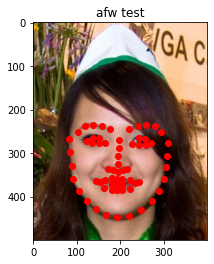

In [48]:
img = Image.open(os.path.join(dataset_afw_path, '1051618982_1' + '.jpg'))

# crop
img_array = np.array(img)
nimg_array = img_array[0:500, 400:800]
nimg = Image.fromarray(nimg_array)

plt.figure("afw test") 
plt.imshow(nimg)
plt.scatter(x,y,color='r')
plt.title('afw test') 
plt.show()